# Lab 7 - Reinforcement Learning 

- Name: James Voight
- Date: 12/2/25

## Imports

In [21]:
%%capture
!pip install gymnasium==0.28.1
!pip install swig
!pip install gymnasium[box2d]==0.28.1
!pip install "stable-baselines3[extra]"
!rm rltools -r
!git clone https://github.com/drbeane/rltools.git

In [22]:
import pandas as pd
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import time

import rltools.gym as gym 
import rltools
from rltools.utils import RandomAgent, FnAgent, evaluate, create_gif
from rltools.monte_carlo import MCAgent
from rltools.temp_diff import TDAgent

from rltools.utils import SB3Agent, sb3_evaluation_curves

from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback

import warnings
warnings.filterwarnings('ignore')

## Part 1: Create Environment

State Space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action Space: Discrete(2)
Initial State: [ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


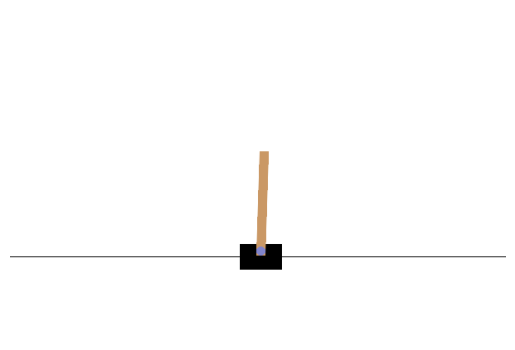

In [23]:
# Create environment
env = gym.make("CartPole-v1", render_mode="rgb_array")

# Print spaces
print("State Space:", env.observation_space)
print("Action Space:", env.action_space)

# Reset env
state, _ = env.reset(seed=42)
print("Initial State:", state)

# Display environment frame
plt.imshow(env.render())
plt.axis("off")
plt.show()

## Part 2: Random Agent

Mean Return:    46.891
StdDev Return:  15.0174
Mean Length:    47.891
StdDev Length:  15.0174
37 steps completed.
Cumulative reward: 36.0


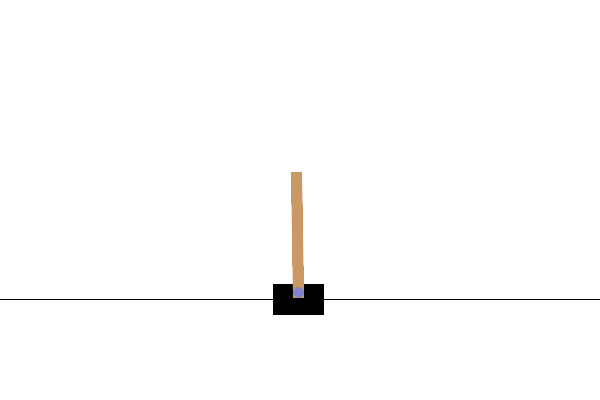

In [24]:
# a) Create an instance of RandomAgent for the environment from Part 1
random_agent = RandomAgent(env)

# b) Evaluate the random agent using 1000 episodes, gamma=1.0, seed=1
eval_results = evaluate(
    env,
    random_agent,
    gamma=1.0,
    episodes=1000,
    max_steps=1000,
    seed=1,
    check_success=False
)

# c) Create a GIF animation of one episode (pick any seed you like)
create_gif(
    env,
    random_agent,
    max_steps=1000,
    folder="gifs",
    filename="random_agent",
    seed=18
)


## Part 3: Policy A

Mean Return:    158.312
StdDev Return:  28.1448
Mean Length:    159.312
StdDev Length:  28.1448
201 steps completed.
Cumulative reward: 200.0


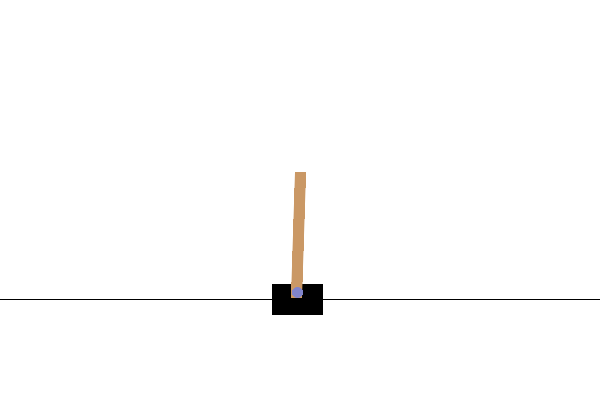

In [25]:
def policy_a(state):
    return 0 if state[2] < 0 else 1

agentA = FnAgent(policy_a)

results_A = evaluate(
    env,
    agentA,
    gamma=1.0,
    episodes=1000,
    max_steps=1000,
    seed=1,
    check_success=False
)

create_gif(
        env,
        agentA,
        max_steps=1000,
        folder="gifs",
        filename="policyA",
        seed=2
    )


## Part 4: Policy B

Mean Return:    157.8
StdDev Return:  27.7756
Mean Length:    158.8
StdDev Length:  27.7756
Policy B Mean Return: 157.8
136 steps completed.
Cumulative reward: 135.0


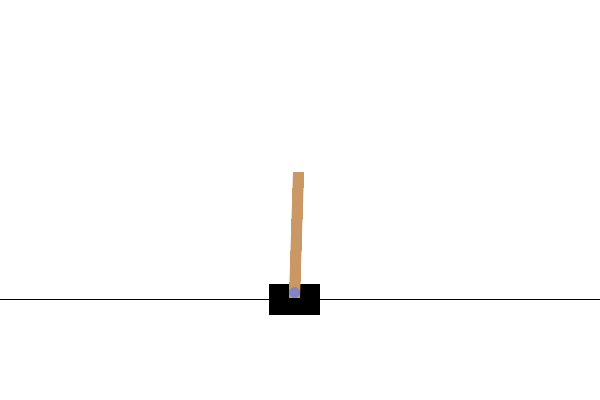

In [26]:
K = 0.0001   # radians

# a) two-mode policy using angle + angular velocity
def policy_b(state):
    angle   = state[2]   # pole angle
    ang_vel = state[3]   # pole angular velocity

    # Large tilt
    if abs(angle) > K:
        if angle > 0:
            return 1
        else:
            return 0
    else:
        # Small tilt
        if ang_vel > 0:
            return 0
        else:
            return 1

# b) create agent that follows this policy
agentB = FnAgent(policy_b)

# c) evaluate over 1000 episodes
results_B = evaluate(
    env,
    agentB,
    gamma=1.0,
    episodes=1000,
    max_steps=1000,
    seed=1,
    check_success=False
)

print("Policy B Mean Return:", results_B["mean_return"])

# create GIF of one episode
create_gif(
    env,
    agentB,
    max_steps=1000,
    folder="gifs",
    filename="policyB",
    seed=3
)


## Part 5: Create Discretized Environment

In [27]:
# Discretized CartPole environment
env = gym.make("CartPole-v1", num_bins=25, render_mode="rgb_array")


## Part 6: Monte Carlo Control

In [28]:
mc_agent = MCAgent(env, gamma=1.0)

# 6b) Train with given parameters
mc_agent.control(
    episodes=20_000,      # train for 20,000 episodes
    max_steps=1000,
    alpha=0.2,            # learning rate
    alpha_decay=1e-4,     # learning rate decay
    epsilon=1.0,          # exploration rate
    epsilon_decay=1e-4,   # exploration decay
    exploring_starts=False,
    updates=1000,
    eval_eps=100,
    check_success=False,
    seed=1
)

# 6c) Evaluate learned policy
results_mc = evaluate(
    env,
    mc_agent,
    gamma=1.0,
    episodes=500,
    max_steps=1000,
    seed=1,
    check_success=False
)

print("MC mean return:", results_mc["mean_return"])
print("MC std return:", results_mc["stdev_return"])
print("MC Score (mean - stdev):", results_mc["mean_return"] - results_mc["stdev_return"])


Episode   Mean[Return]  SD[Return]  Mean[Length]  SD[Length]
------------------------------------------------------------
1000          129.0900     38.0387      130.0900     38.0387  (Saving new best model)
2000          169.7800     77.0246      170.7800     77.0246  (Saving new best model)
3000          121.4000     26.7597      122.4000     26.7597  (Saving new best model)
4000          227.8600     92.5611      228.8600     92.5611  (Saving new best model)
5000          160.1600     92.5282      161.1600     92.5282  
6000          202.9500     75.5360      203.9500     75.5360  
7000          882.2600    260.0667      882.4600    259.7046  (Saving new best model)
8000          173.6100     61.6107      174.6100     61.6107  
9000          858.8400    245.6701      859.1400    245.2680  
10000         290.7900    165.1320      291.7900    165.1320  
11000         664.2000    300.5874      664.8400    300.1853  
12000         760.6600    316.8143      761.0800    316.3762  
13000  

### Improved values

In [29]:
mc_agent = MCAgent(env, gamma=1.0)

# 6b) Train with given parameters
mc_agent.control(
    episodes=20_000,      # train for 20,000 episodes
    max_steps=1000,
    alpha=0.1,            # learning rate
    alpha_decay=1e-4,     # learning rate decay
    epsilon=1.0,          # exploration rate
    epsilon_decay=1e-4,   # exploration decay
    exploring_starts=False,
    updates=1000,
    eval_eps=100,
    check_success=False,
    seed=1
)

# 6c) Evaluate learned policy
results_mc = evaluate(
    env,
    mc_agent,
    gamma=1.0,
    episodes=500,
    max_steps=1000,
    seed=1,
    check_success=False
)

print("MC mean return:", results_mc["mean_return"])
print("MC std return:", results_mc["stdev_return"])
print("MC Score (mean - stdev):", results_mc["mean_return"] - results_mc["stdev_return"])


Episode   Mean[Return]  SD[Return]  Mean[Length]  SD[Length]
------------------------------------------------------------
1000          127.3000     53.6473      128.3000     53.6473  (Saving new best model)
2000          131.0300     38.3115      132.0300     38.3115  (Saving new best model)
3000          135.7300     35.1912      136.7300     35.1912  (Saving new best model)
4000          264.2800    162.1722      265.2600    162.0815  (Saving new best model)
5000          144.8800     40.1533      145.8800     40.1533  (Saving new best model)
6000          490.2600    302.3025      491.1000    302.0328  (Saving new best model)
7000          268.0100    143.3516      269.0100    143.3516  
8000          507.2400    276.0282      508.0900    275.7605  (Saving new best model)
9000          724.4000    300.1960      725.0000    299.8290  (Saving new best model)
10000         794.5000    303.2289      794.9200    302.8360  (Saving new best model)
11000         919.9400    215.8025      9

## Part 7: Temporal Difference Q-Learning

In [30]:
# Temporal Difference – Q-Learning

# a) Create TD agent for the discretized environment
td_agent = TDAgent(env, gamma=1.0)

# b) Apply Q-Learning with the specified parameters
td_agent.q_learning(
    episodes=20_000,      # train for 20,000 episodes
    max_steps=1000,       # max_steps = 1000
    seed=1,               # seed = 1
    exploring_starts=False,
    check_success=False,
    updates=1000,
    eval_eps=100,
    alpha=0.3,            # learning rate
    alpha_decay=5e-6,     # learning rate decay
    epsilon=1.0,          # exploration rate
    epsilon_decay=5e-4    # exploration rate decay
)

# c) Evaluate the learned policy
results_td = evaluate(
    env,
    td_agent,
    gamma=1.0,
    episodes=500,
    seed=1,
    max_steps=1000,
    check_success=False
)

# Score - in this case using mean
print("TD Score (mean return):", results_td["mean_return"])


Episode   Mean[Return]  SD[Return]  Mean[Length]  SD[Length]
------------------------------------------------------------
1000          307.9900    252.5235      308.9300    252.3591  (Saving new best model)
2000          119.7300     29.6438      120.7300     29.6438  (Saving new best model)
3000          170.1900     52.1906      171.1900     52.1906  (Saving new best model)
4000          295.2400    183.2607      296.2300    183.2223  
5000          653.0500    316.1037      653.7100    315.7307  (Saving new best model)
6000          299.2900     79.9014      300.2900     79.9014  
7000          906.0300    216.4010      906.2200    216.0493  (Saving new best model)
8000         1000.0000      0.0000     1000.0000      0.0000  (Saving new best model)
9000          968.5700    151.9517      968.6300    151.7573  
10000         933.8800    190.4762      934.0200    190.1778  
11000        1000.0000      0.0000     1000.0000      0.0000  
12000        1000.0000      0.0000     1000.000

## Part 8: DQN

Eval num_timesteps=1000, episode_reward=21.75 +/- 0.43
Episode length: 22.75 +/- 0.43
New best mean reward!
Eval num_timesteps=2000, episode_reward=21.80 +/- 0.40
Episode length: 22.80 +/- 0.40
New best mean reward!
Eval num_timesteps=3000, episode_reward=45.00 +/- 2.21
Episode length: 46.00 +/- 2.21
New best mean reward!
Eval num_timesteps=4000, episode_reward=38.40 +/- 2.48
Episode length: 39.40 +/- 2.48
Eval num_timesteps=5000, episode_reward=77.90 +/- 27.56
Episode length: 78.90 +/- 27.56
New best mean reward!
Eval num_timesteps=6000, episode_reward=97.75 +/- 14.00
Episode length: 98.75 +/- 14.00
New best mean reward!
Eval num_timesteps=7000, episode_reward=93.95 +/- 11.35
Episode length: 94.95 +/- 11.35
Eval num_timesteps=8000, episode_reward=65.55 +/- 4.36
Episode length: 66.55 +/- 4.36
Eval num_timesteps=9000, episode_reward=70.30 +/- 2.47
Episode length: 71.30 +/- 2.47
Eval num_timesteps=10000, episode_reward=75.45 +/- 5.03
Episode length: 76.45 +/- 5.03
Eval num_timesteps=1100

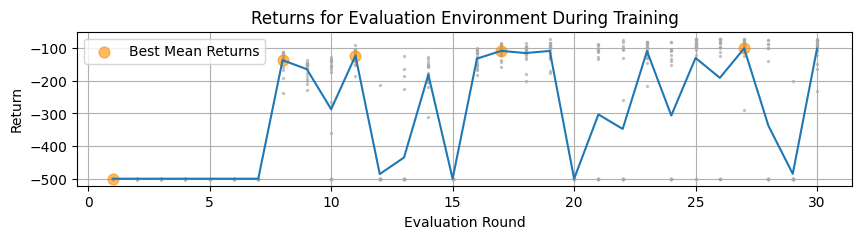

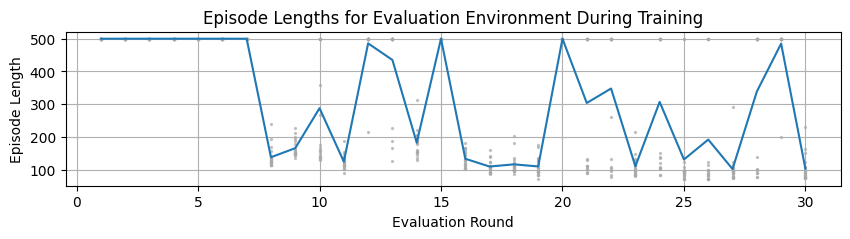

Mean Return:    1000.0
StdDev Return:  0.0
Mean Length:    1000.0
StdDev Length:  0.0
DQN Score: 1000.0
124 steps completed.
Cumulative reward: 123.0


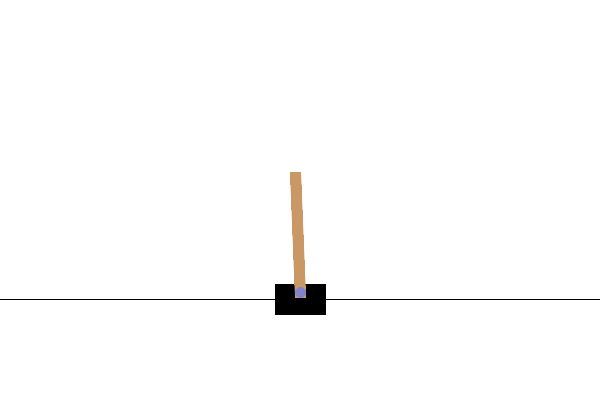

In [31]:
# a) Create 3 environments
train_env = gym.make("CartPole-v1")
eval_env  = gym.make("CartPole-v1")
test_env  = gym.make("CartPole-v1", render_mode="rgb_array")

# Set max pole angle directly on each env
for env in [train_env, eval_env, test_env]:
    env.unwrapped.theta_threshold_radians = 0.21

# b) Reset training and evaluation envs with seed=1
_, _ = train_env.reset(seed=1)
_, _ = eval_env.reset(seed=1)

# c) Evaluation callback
eval_callback = EvalCallback(
    eval_env,
    eval_freq=1000,
    n_eval_episodes=20,
    best_model_save_path="./dqn_cartpole",
    log_path="./dqn_cartpole",
    warn=False
)

# d) Create DQN model
policy_kwargs = dict(net_arch=[256, 256])

model = DQN(
    policy="MlpPolicy",
    env=train_env,
    learning_rate=0.001,
    gamma=0.99,
    exploration_fraction=0.2,
    exploration_final_eps=0.02,
    target_update_interval=10,
    train_freq=256,
    gradient_steps=-1,
    batch_size=64,
    buffer_size=100_000,
    learning_starts=1000,
    policy_kwargs=policy_kwargs,
    seed=1,
    verbose=0
)

# e) Train (30,000 timesteps)
model.learn(
    total_timesteps=30_000,
    callback=eval_callback
)

# f) Plot evaluation curves
sb3_evaluation_curves(path='evaluation/')

# g) Load & evaluate best model
best_model = DQN.load("./dqn_cartpole/best_model", env=test_env)

dqn_agent = SB3Agent(best_model)

results = evaluate(
    test_env,
    dqn_agent,
    gamma=1.0,
    episodes=100,
    max_steps=1000,
    seed=1,
    check_success=False
)

print("DQN Score:", results["mean_return"])


# h) GIF
create_gif(
    env,
    agentB,
    max_steps=1000,
    folder="gifs",
    filename="DQN",
    seed=1
)